In [9]:
import os
import re
import time
import json
import openai
import numpy as np
import traceback
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv

import langchain.chat_models
import langchain.schema
from langchain.callbacks import get_openai_callback
from langchain import OpenAI
from langchain.schema import (HumanMessage, AIMessage)

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

_ = load_dotenv(find_dotenv())
open_api_key = os.environ["OPENAI_API_KEY"]

from openai_textgen import TextGenerator
from summarizer import Summarizer
from datamodel import Message, LLMResponse, Summary

# Test TextGenerator Class

In [2]:
config =  {'temperature' : 0, 'max_tokens': 300, 'n': 3}
chatbot = TextGenerator()
prompt = "It seems like today is cold in bay area time to get cozy in the house. what do you think?"
messages = [
    {
        "role": "system",
        "content": "You are a sassy funny assistant tasked to respond in a sarcastic tone",
    },
    {
        "role": "user",
        "content": f"{prompt}"
    }
]
res = chatbot.generate(messages=messages, config=config)
res.text

[Message(role='assistant', content="Oh, absolutely! Because who doesn't love freezing their buns off in the comfort of their own home? It's just so much fun to bundle up in layers upon layers and hibernate like a bear until the sun decides to grace us with its presence again. So cozy, I can hardly contain my excitement!"),
 Message(role='assistant', content="Oh, absolutely! Because who doesn't love freezing their buns off in the comfort of their own home? It's just so much fun to bundle up in layers upon layers and hibernate like a bear until the sun decides to grace us with its presence again. So cozy, I can hardly contain my excitement!"),
 Message(role='assistant', content="Oh, absolutely! Because who doesn't love freezing their buns off in the comfort of their own home? It's just so much fun to bundle up in layers upon layers and hibernate like a bear until the sun decides to grace us with its presence again. So cozy, I can hardly contain my excitement!")]

# Test Summerizer Class

In [3]:
text_gen_config = {'max_tokens':2000}
text_gen = TextGenerator()
df = pd.read_excel("../data/ROBERT_KING.xlsx", index_col=0)
get_summary = Summarizer()

In [4]:
summary_default = get_summary.summarize(data=df, n_samples=3, text_gen=text_gen, textgen_config=text_gen_config, summary_method="default")
display(Summary(**summary_default))


## Dataset Summary

---

**Name:** 

**File Name:** 

**Dataset Description:**



**Fields:**

- **Date:** {'column': 'Date', 'properties': {'dtype': 'date', 'min': '2023-08-01', 'max': '2023-11-01', 'samples': ['2023-09-10', '2023-08-23', '2023-09-25'], 'num_unique_values': 93, 'semantic_type': '', 'description': ''}}
- **Account_Number:** {'column': 'Account_Number', 'properties': {'dtype': 'number', 'std': 0, 'min': 1012345678, 'max': 1012345679, 'samples': [1012345679, 1012345678], 'num_unique_values': 2, 'semantic_type': '', 'description': ''}}
- **Transaction_Type:** {'column': 'Transaction_Type', 'properties': {'dtype': 'category', 'samples': ['ACH', 'Transfer'], 'num_unique_values': 6, 'semantic_type': '', 'description': ''}}
- **Transaction_Purpose:** {'column': 'Transaction_Purpose', 'properties': {'dtype': 'category', 'samples': ['Bills & utilities', 'Investment'], 'num_unique_values': 16, 'semantic_type': '', 'description': ''}}
- **Transaction_Amount:** {'column': 'Transaction_Amount', 'properties': {'dtype': 'number', 'std': 67302.40037054197, 'min': -120000.0, 'max': 250000.0, 'samples': [-85.0, -320.5], 'num_unique_values': 69, 'semantic_type': '', 'description': ''}}
- **Transaction_Description:** {'column': 'Transaction_Description', 'properties': {'dtype': 'string', 'samples': ["POS PURCHASE #2468 BARRY'S BOOTCAMP PACKAGE SF", 'ACH DEBIT LEGAL FEES FOR HEDGE FUND A CONSULTATION'], 'num_unique_values': 68, 'semantic_type': '', 'description': ''}}


In [5]:
summary_llm = get_summary.summarize(data=df, n_samples=3, text_gen=text_gen, textgen_config=text_gen_config, summary_method="llm")
display(Summary(**summary_llm))


## Dataset Summary

---

**Name:** Bank Transactions

**File Name:** 

**Dataset Description:**

A dataset containing bank transactions

**Fields:**

- **Date:** {'column': 'Date', 'properties': {'dtype': 'date', 'min': '2023-08-01', 'max': '2023-11-01', 'samples': ['2023-09-10', '2023-08-23', '2023-09-25'], 'num_unique_values': 93, 'semantic_type': 'date', 'description': 'The date of the transaction'}}
- **Account_Number:** {'column': 'Account_Number', 'properties': {'dtype': 'number', 'std': 0, 'min': 1012345678, 'max': 1012345679, 'samples': [1012345679, 1012345678], 'num_unique_values': 2, 'semantic_type': 'account_number', 'description': 'The account number associated with the transaction'}}
- **Transaction_Type:** {'column': 'Transaction_Type', 'properties': {'dtype': 'category', 'samples': ['ACH', 'Transfer'], 'num_unique_values': 6, 'semantic_type': 'transaction_type', 'description': 'The type of transaction'}}
- **Transaction_Purpose:** {'column': 'Transaction_Purpose', 'properties': {'dtype': 'category', 'samples': ['Bills & utilities', 'Investment'], 'num_unique_values': 16, 'semantic_type': 'transaction_purpose', 'description': 'The purpose of the transaction'}}
- **Transaction_Amount:** {'column': 'Transaction_Amount', 'properties': {'dtype': 'number', 'std': 67302.40037054197, 'min': -120000.0, 'max': 250000.0, 'samples': [-85.0, -320.5], 'num_unique_values': 69, 'semantic_type': 'transaction_amount', 'description': 'The amount of the transaction'}}
- **Transaction_Description:** {'column': 'Transaction_Description', 'properties': {'dtype': 'string', 'samples': ["POS PURCHASE #2468 BARRY'S BOOTCAMP PACKAGE SF", 'ACH DEBIT LEGAL FEES FOR HEDGE FUND A CONSULTATION'], 'num_unique_values': 68, 'semantic_type': 'transaction_description', 'description': 'The description of the transaction'}}


# Test Vizualization Goal Generation

In [6]:
import json
import logging
from utils import clean_code_snippet
from openai_textgen import TextGenerator
from datamodel import Goal, Persona

SYSTEM_INSTRUCTIONS = """
You are a an experienced data analyst who can generate a given number of insightful GOALS about data, when given a summary of the data, and a specified persona. The VISUALIZATIONS YOU RECOMMEND MUST FOLLOW VISUALIZATION BEST PRACTICES (e.g., must use bar charts instead of pie charts for comparing quantities) AND BE MEANINGFUL (e.g., plot longitude and latitude on maps where appropriate). They must also be relevant to the specified persona. Each goal must include a question, a visualization (THE VISUALIZATION MUST REFERENCE THE EXACT COLUMN FIELDS FROM THE SUMMARY), and a rationale (JUSTIFICATION FOR WHICH dataset FIELDS ARE USED and what we will learn from the visualization). Each goal MUST mention the exact fields from the dataset summary above
"""

FORMAT_INSTRUCTIONS = """
THE OUTPUT MUST BE A CODE SNIPPET OF A VALID LIST OF JSON OBJECTS. IT MUST USE THE FOLLOWING FORMAT:

```[
    { "index": 0,  "question": "What is the distribution of X", "visualization": "histogram of X", "rationale": "This tells about "} ..
    ]
```
THE OUTPUT SHOULD ONLY USE THE JSON FORMAT ABOVE.
"""

logger = logging.getLogger("chat2vis")


class GoalExplorer():
    """Generat goals given a summary of data"""

    def __init__(self) -> None:
        pass

    def generate(self, summary: dict, textgen_config: dict,
                 text_gen: TextGenerator, n=5, persona: Persona = None) -> list[Goal]:
        """Generate goals given a summary of data"""

        user_prompt = f"""The number of GOALS to generate is {n}. The goals should be based on the data summary below, \n\n .
        {summary} \n\n"""

        if not persona:
            persona = Persona(
                persona="A highly skilled data analyst who can come up with complex, insightful goals about data",
                rationale="")

        user_prompt += f"""\n The generated goals SHOULD BE FOCUSED ON THE INTERESTS AND PERSPECTIVE of a '{persona.persona} persona, who is insterested in complex, insightful goals about the data. \n"""

        messages = [
            {"role": "system", "content": SYSTEM_INSTRUCTIONS},
            {"role": "assistant",
             "content":
             f"{user_prompt}\n\n {FORMAT_INSTRUCTIONS} \n\n. The generated {n} goals are: \n "}]

        result: list[Goal] = text_gen.generate(messages=messages, config=textgen_config)

        try:
            json_string = clean_code_snippet(result.text[0].content)
            result = json.loads(json_string)
            # cast each item in the list to a Goal object
            if isinstance(result, dict):
                result = [result]
            result = [Goal(**x) for x in result]
        except json.decoder.JSONDecodeError:
            logger.info(f"Error decoding JSON: {result.text[0].content}")
            print(f"Error decoding JSON: {result.text[0].content}")
            raise ValueError(
                "The model did not return a valid JSON object while attempting generate goals. Consider using a larger model or a model with higher max token length.")
        return result

In [7]:
text_gen_config = {'max_tokens':2000}
text_gen = TextGenerator(model_name='gpt-3.5-turbo')
df = pd.read_excel("../data/ROBERT_KING.xlsx", index_col=0)
goals_explorer = GoalExplorer()
goals = goals_explorer.generate(summary=summary_llm, textgen_config=text_gen_config, text_gen=text_gen, n=3)
for goal in goals:
    display(goal)


### Goal 0
---
**Question:** What is the distribution of transaction amounts?

**Visualization:** `histogram of Transaction_Amount`

**Rationale:** This visualization will show the frequency and range of transaction amounts, allowing us to understand the distribution of transaction amounts in the dataset. This can help identify any outliers or patterns in the transaction amounts.



### Goal 1
---
**Question:** What are the most common transaction types?

**Visualization:** `bar chart of Transaction_Type`

**Rationale:** By visualizing the transaction types in a bar chart, we can easily identify the most common transaction types. This can provide insights into the most frequently occurring transaction types and help identify any trends or patterns in the data.



### Goal 2
---
**Question:** What is the distribution of transaction purposes?

**Visualization:** `bar chart of Transaction_Purpose`

**Rationale:** By visualizing the transaction purposes in a bar chart, we can understand the distribution of transaction purposes. This can help identify the most common transaction purposes and provide insights into the different categories of transactions in the dataset.


# Test Visualization Generator

In [8]:
from openai_textgen import TextGenerator
from datamodel import Goal, LLMResponse


system_prompt = """
You are a helpful assistant highly skilled in writing PERFECT code for visualizations. Given some code template, you complete the template to generate a visualization given the dataset and the goal described. The code you write MUST FOLLOW VISUALIZATION BEST PRACTICES ie. meet the specified goal, apply the right transformation, use the right visualization type, use the right data encoding, and use the right aesthetics (e.g., ensure axis are legible). The transformations you apply MUST be correct and the fields you use MUST be correct. The visualization CODE MUST BE CORRECT and MUST NOT CONTAIN ANY SYNTAX OR LOGIC ERRORS (e.g., it must consider the field types and use them correctly). You MUST first generate a brief plan for how you would solve the task e.g. what transformations you would apply e.g. if you need to construct a new column, what fields you would use, what visualization type you would use, what aesthetics you would use, etc. .
"""

class VizGenerator:
    """Generate visualizations from prompt"""
    def __init__(self) -> None:
        pass

    def get_template(self, goal: str, library: str = 'matplotlib'):
        general_instructions = f"If the solution requires a single value (e.g. max, min, median, first, last etc), ALWAYS add a line (axvline or axhline) to the chart, ALWAYS with a legend containing the single value (formatted with 0.2F). If using a <field> where semantic_type=date, YOU MUST APPLY the following transform before using that column i) convert date fields to date types using data[''] = pd.to_datetime(data[<field>], errors='coerce'), ALWAYS use  errors='coerce' ii) drop the rows with NaT values data = data[pd.notna(data[<field>])] iii) convert field to right time format for plotting.  ALWAYS make sure the x-axis labels are legible (e.g., rotate when needed). Solve the task  carefully by completing ONLY the <imports> AND <stub> section. Given the dataset summary, the plot(data) method should generate a {library} chart ({goal.visualization}) that addresses this goal: {goal.question}. DO NOT WRITE ANY CODE TO LOAD THE DATA. The data is already loaded and available in the variable data."

        matplotlib_instructions = f"{general_instructions} DO NOT include plt.show(). The plot method must return a matplotlib object (plt). Think step by step. \n"

        if library == "matplotlib":
            instructions = {
                "role": "assistant",
                "content": f"  {matplotlib_instructions}. Use BaseMap for charts that require a map. "}
            template = \
                f"""
import matplotlib.pyplot as plt
import pandas as pd
<imports>
# plan -
def plot(data: pd.DataFrame):
    <stub> # only modify this section
    plt.title('{goal.question}', wrap=True)
    return plt;

chart = plot(data) # data already contains the data to be plotted. Always include this line. No additional code beyond this line."""
        else:
            raise ValueError("Unsupported library. Only 'matplotlib' is supported.")
        return template, instructions
    

    def generate(self, summary: dict, goal: Goal,
                 textgen_config: dict, text_gen: TextGenerator, library='matplotlib'):
        """Generate visualization code given a summary and a goal"""

        library_template, library_instructions = self.get_template(goal, library)
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "system", "content": f"The dataset summary is : {summary} \n\n"},
            library_instructions,
            {"role": "user",
             "content":
             f"Always add a legend with various colors where appropriate. The visualization code MUST only use data fields that exist in the dataset (field_names) or fields that are transformations based on existing field_names. Only use variables that have been defined in the code or are in the dataset summary. You MUST return a FULL PYTHON PROGRAM ENCLOSED IN BACKTICKS ``` that starts with an import statement. DO NOT add any explanation. \n\n THE GENERATED CODE SOLUTION SHOULD BE CREATED BY MODIFYING THE SPECIFIED PARTS OF THE TEMPLATE BELOW \n\n {library_template} \n\n.The FINAL COMPLETED CODE BASED ON THE TEMPLATE above is ... \n\n"}]
        
        self.messages = messages

        completions: LLMResponse = text_gen.generate(
            messages=messages, config=textgen_config)
        response = [x.content for x in completions.text]

        return response



In [9]:
question = "analyze the distribution of transaction amounts across different transaction types"
text_gen_config = {'max_tokens':2000}
text_gen = TextGenerator(model_name='gpt-3.5-turbo')
df = pd.read_excel("../data/ROBERT_KING.xlsx", index_col=0)
viz_gen = VizGenerator()
viz_code = viz_gen.generate(summary=summary_llm, goal=Goal(question=question, visualization=question, rationale=""),textgen_config=text_gen_config, text_gen=text_gen)

# Test Executing the plot

In [10]:

import base64
import io
import traceback
from typing import Any, List
import matplotlib.pyplot as plt
import pandas as pd
from datamodel import ChartExecutorResponse, Summary
from utils import preprocess_code, get_globals_dict


class ChartExecutor:
    """Execute code and return chart object"""

    def __init__(self) -> None:
        pass

    def execute(
        self,
        code_specs: List[str],
        data: Any,
        library="matplotlib",
        return_error: bool = False,
    ) -> Any:
        """Validate and convert code"""

        charts = []
        code_spec_copy = code_specs.copy()
        code_specs = [preprocess_code(code) for code in code_specs]
        if library == "matplotlib":
            for code in code_specs:
                try:
                    ex_locals = get_globals_dict(code, data)
                    # print(ex_locals)
                    exec(code, ex_locals)
                    chart = ex_locals["chart"]
                    if plt:
                        # hold the image data in the memory
                        buf = io.BytesIO()
                        plt.box(False)
                        plt.grid(color="lightgray", linestyle="dashed", zorder=-10)
                        plt.tight_layout()
                        # try:
                        #     plt.draw()
                        #     # plt.tight_layout()
                        # except AttributeError:
                        #     print("Warning: tight_layout encountered an error. The layout may not be optimal.")
                        #     pass

                        plt.savefig(buf, format="png", dpi=100, pad_inches=3)
                        buf.seek(0)
                        # now the conent of the buffer is (containig the image data) are read and encoded into base64 format in text form which can be used stored or transmitted over the web
                        plot_data = base64.b64encode(buf.read()).decode("ascii")
                        plt.close()
                    charts.append(
                        ChartExecutorResponse(
                            status=True,
                            raster=plot_data,
                            code=code,
                            library=library,
                        )
                    )
                except Exception as exception_error:
                    print(code_spec_copy[0])
                    print("****\n", str(exception_error))
                    # print(traceback.format_exc())
                    if return_error:
                        charts.append(
                            ChartExecutorResponse(
                                status=False,
                                raster=None,
                                code=code,
                                library=library,
                                error={
                                    "message": str(exception_error),
                                    "traceback": traceback.format_exc(),
                                },
                            )
                        )
            return charts
        else:
            raise Exception(
                f"Unsupported library. Only matplotlib library is supported."
            )

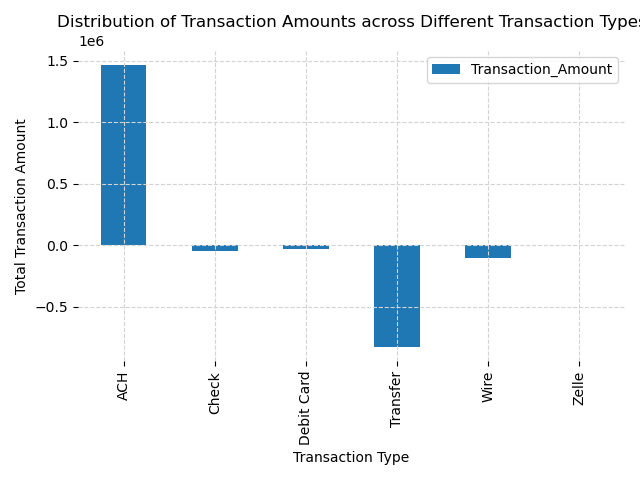

In [11]:
chart_exec = ChartExecutor()
charts = chart_exec.execute(code_specs=viz_code, data=df, return_error=True)
charts[0]

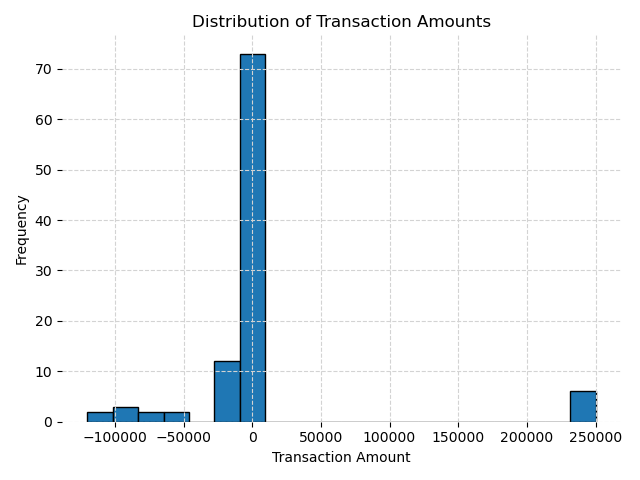

In [14]:
question = "What is the distribution of transaction amounts?"
text_gen_config = {'temperature':0.0}
text_gen = TextGenerator(model_name='gpt-3.5-turbo')
df = pd.read_excel("../data/ROBERT_KING.xlsx", index_col=0)
viz_gen = VizGenerator()
viz_code = viz_gen.generate(summary=summary_llm, goal=Goal(question=question, visualization='histogram of Transaction_Amount', rationale=""),textgen_config=text_gen_config, text_gen=text_gen)
chart_exec = ChartExecutor()
charts = chart_exec.execute(code_specs=viz_code, data=df, return_error=True)
charts[0]

In [13]:
viz_gen.messages

[{'role': 'system',
  'content': '\nYou are a helpful assistant highly skilled in writing PERFECT code for visualizations. Given some code template, you complete the template to generate a visualization given the dataset and the goal described. The code you write MUST FOLLOW VISUALIZATION BEST PRACTICES ie. meet the specified goal, apply the right transformation, use the right visualization type, use the right data encoding, and use the right aesthetics (e.g., ensure axis are legible). The transformations you apply MUST be correct and the fields you use MUST be correct. The visualization CODE MUST BE CORRECT and MUST NOT CONTAIN ANY SYNTAX OR LOGIC ERRORS (e.g., it must consider the field types and use them correctly). You MUST first generate a brief plan for how you would solve the task e.g. what transformations you would apply e.g. if you need to construct a new column, what fields you would use, what visualization type you would use, what aesthetics you would use, etc. .\n'},
 {'rol

# Test the entire app

In [30]:
import pandas as pd
import logging
from summarizer import Summarizer
from goal import GoalExplorer
from vizgen import VizGenerator
from executor import ChartExecutor
from typing import Union, Optional
from datamodel import (Summary, ChartExecutorResponse, Persona, Goal)
from openai_textgen import TextGenerator
from utils import read_dataframe

class Manager:

    def __init__(self, text_gen: TextGenerator = None, data: Union[pd.DataFrame, str] = None) -> None:
        
        self.text_gen = text_gen or TextGenerator()
        self.summarizer = Summarizer()
        self.goal = GoalExplorer()
        self.vizgen = VizGenerator()
        self.executor = ChartExecutor()

        if isinstance(data, str):
            file_name = data.split("/")[-1]
            self.data = read_dataframe(data)
        else:
            self.data = data


    def summarize(
        self,
        #data: Union[pd.DataFrame, str],
        file_name: Optional[str] = "",
        n_samples: int = 3,
        summary_method: str = "default",
        textgen_config: dict = {"n":1, "temperature":0}
    ) -> Summary:
        """ Summarize data given a DataFrame or file path."""

        return self.summarizer.summarize(
            data=self.data, text_gen=self.text_gen, file_name=file_name, n_samples=n_samples, 
            summary_method=summary_method, textgen_config=textgen_config)
    

    def goals(
        self,
        summary: dict,
        textgen_config: dict,
        n: int =5, 
        persona: Persona = None
    ) -> list[Goal]:
        """ Generate goals based on a sumamry and persona"""
        
        if isinstance(persona, str):
            persona = Persona(person=persona, rationale="")
        if isinstance(persona, dict):
            persona = Persona(**persona)

        return self.goal.generate(
            summary=summary, textgen_config=textgen_config, text_gen=self.text_gen, n=n, persona=persona
        )


    # def execute(
    #     self,
    #     code_specs: List[str],
    #     data: Any,
    #     library="matplotlib",
    #     return_error: bool = False,
    # ) -> Any:
    #      return self.executor.execute()
         

    def visualize(
        self,
        summary: dict,
        goal: Goal,
        textgen_config: dict,
        library: str = 'matplotlib',
        return_error: bool = False
    ):
        if isinstance(goal, dict):
            goal = Goal(**goal)
        if isinstance(goal, str): 
            goal = Goal(question=goal, visualization=goal, rationale="")
        
        code_specs = self.vizgen.generate(
            summary=summary, 
            goal=goal, 
            textgen_config=textgen_config, 
            text_gen=self.text_gen, 
            library=library
        )

        return self.executor.execute(code_specs=code_specs, data=self.data, library=library, return_error=return_error)

In [18]:
llm_config = {"n":1, 'max_tokens':2000, "temperature": 0, }
text_gen = TextGenerator()
df = pd.read_excel("../data/ROBERT_KING.xlsx", index_col=0)

nlviz = Manager(text_gen=text_gen, data=df)
data_summary = nlviz.summarize(df, textgen_config=llm_config, summary_method="llm")


In [32]:
nlviz = Manager(text_gen=text_gen, data=df)
question = "what is the distribution of transaction purposes ?"
charts = nlviz.visualize(summary=data_summary, goal=question, textgen_config=llm_config, return_error=True)

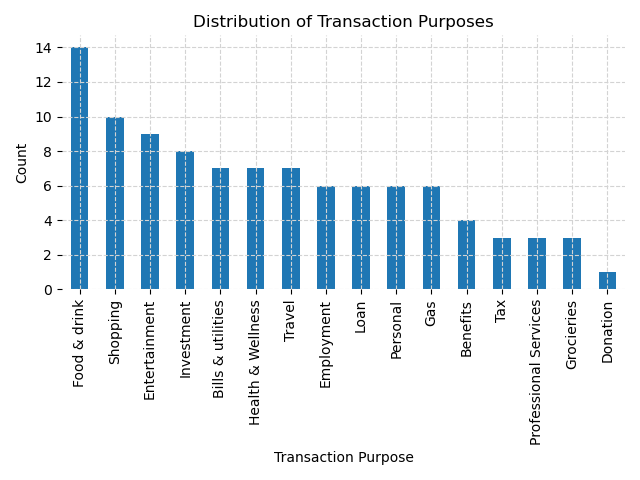

In [42]:
charts[0]